In [1]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
import numpy as np

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Override/set credentials in env var
os.environ['CWD'] = str(Path(os.getcwd()).parent)

# Base paths
cwd = Path(os.environ['CWD'])
dir_data = cwd / 'data'
dir_models = cwd / 'models'
dir_models.mkdir(exist_ok=True, parents=True)


import pickle
def picklesave(o, f):
    with open(f, 'wb') as fp:
        pickle.dump(o, fp)
        
def pickleload(f):
    with open(f, 'rb') as fp:
        return pickle.load(fp)


from tqdm import tqdm 
tqdm.pandas()

In [2]:
# !pip install -e ..

# Load data

In [3]:
import pandas as pd

df_tr_ev = pd.read_csv(dir_data / 'train.csv')
df_tr_ev['split'] = 'tr'
df_te = pd.read_csv(dir_data / 'test.csv')
df_te['split'] = 'te'

df = pd.concat([df_tr_ev, df_te])

# Feature Extraction

## Set punctuation features (statistics) from unprocessed texts

In [4]:
from author_classification.feature_extraction import get_text_punctuation_stat_features
df_tr_ev['dict_punct_features'] = df_tr_ev['text'].progress_apply(get_text_punctuation_stat_features)

punctuation_feature_names = df_tr_ev['dict_punct_features'].iloc[0].keys()

# Put each punctuation feature in a column in the dataframe
from author_classification.utils import expand_col_dicts
df_tr_ev = expand_col_dicts(df_tr_ev, colname_dict='dict_punct_features')

2022-04-25 18:07:28.327961: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-25 18:07:28.328005: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
100%|███████████████████████████████████| 40000/40000 [00:08<00:00, 4572.18it/s]


## Sentiment and readability from unprocessed texts

In [5]:
from author_classification.feature_extraction import (
    set_text_readability_statistics, set_text_polarity_subjectivity, LIST_TUPLES_READABILITY_STATISTICS
)
df_tr_ev = set_text_readability_statistics(df_tr_ev, colname_text='text')
df_tr_ev = set_text_polarity_subjectivity(df_tr_ev, colname_text='text')

df_measures_per_author = df_tr_ev.groupby('author').agg(
    {
        **{'polarity': list, 'subjectivity': list},
        **{k:list for k in list(zip(*LIST_TUPLES_READABILITY_STATISTICS))[0]}
    }
)

100%|███████████████████████████████████| 40000/40000 [00:16<00:00, 2417.40it/s]


## Preprocess texts

In [6]:
# Preprocess text
from author_classification.preprocessing import preprocess_text
# We should also make another column
df_tr_ev['text_processed'] = df_tr_ev['text'].progress_apply(lambda txt: preprocess_text(txt, lemmatize=True))

100%|████████████████████████████████████| 40000/40000 [03:28<00:00, 191.91it/s]


## n-grams

### Split dataset now to avoid data leakage in tfidf and tsvd

In [7]:
from sklearn.model_selection import train_test_split
df_tr, df_ev = train_test_split(df_tr_ev, test_size=0.15, stratify=df_tr_ev['author'], random_state=288)

### Char-level tfidf on unprocessed texts
Capture fine-grain char-level features

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_char = TfidfVectorizer(
    ngram_range=(1,5),
    analyzer='char',
    min_df=40,
    max_df=0.7
)

X_tfidf_char_tr = tfidf_char.fit_transform(df_tr['text']).astype(np.float32)
print(f'{len(tfidf_char.vocabulary_)} features')
X_tfidf_char_ev = tfidf_char.transform(df_ev['text']).astype(np.float32)

picklesave(tfidf_char, dir_models / 'tfidf_char.pkl')

61903 features


### Reduce dimensionality with TSVD

In [9]:
from sklearn.decomposition import TruncatedSVD

tsvd_char = TruncatedSVD(n_components=1000, random_state=288)
X_tfidf_char_tsvd_tr = tsvd_char.fit_transform(X_tfidf_char_tr)
print(f'Cumulative sum of explained variance ratio kept by tsvd_char: {round(tsvd_char.explained_variance_ratio_.cumsum()[-1], 4)}')
X_tfidf_char_tsvd_ev = tsvd_char.transform(X_tfidf_char_ev)

picklesave(tsvd_char, dir_models / 'tsvd_char.pkl')

Cumulative sum of explained variance ratio kept by tsvd_char: 0.4212000072002411


### Word-level tfidf on processed texts
Capture coarse-grained word-level features, relations between words, etc.

#### Fit word-level tfidf

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_word = TfidfVectorizer(
    ngram_range=(1,2),
    analyzer='word',
    min_df=5,
    max_df=0.7
)

X_tfidf_word_tr = tfidf_word.fit_transform(df_tr['text_processed']).astype(np.float32)
print(f'{len(tfidf_word.vocabulary_)} features')
X_tfidf_word_ev = tfidf_word.transform(df_ev['text_processed']).astype(np.float32)

picklesave(tfidf_word, dir_models / 'tfidf_word.pkl')

29243 features


### Reduce dimensionality with TSVD

In [11]:
from sklearn.decomposition import TruncatedSVD
tsvd_word = TruncatedSVD(n_components=1500, random_state=288)
X_tfidf_word_tsvd_tr = tsvd_word.fit_transform(X_tfidf_word_tr)
print(f'Cumulative sum of explained variance ratio kept by tsvd_word: {round(tsvd_word.explained_variance_ratio_.cumsum()[-1], 4)}')
X_tfidf_word_tsvd_ev = tsvd_word.transform(X_tfidf_word_ev)

picklesave(tsvd_word, dir_models / 'tsvd_word.pkl')

Cumulative sum of explained variance ratio kept by tsvd_word: 0.44040000438690186


In [12]:
from author_classification.feature_extraction import get_feature_matrix_from_dataframe_with_feature_columns

X_tr_stats = get_feature_matrix_from_dataframe_with_feature_columns(df_tr)
X_ev_stats = get_feature_matrix_from_dataframe_with_feature_columns(df_ev)

In [13]:
from sentence_transformers import SentenceTransformer
model_sent_embs = SentenceTransformer('all-MiniLM-L6-v2')
X_sentembs_tr = model_sent_embs.encode(df_tr['text'].values, show_progress_bar=True)
X_sentembs_ev = model_sent_embs.encode(df_ev['text'].values, show_progress_bar=True)

Batches:   0%|          | 0/1063 [00:00<?, ?it/s]

Batches:   0%|          | 0/188 [00:00<?, ?it/s]

In [14]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_tr_stats_scaled = scaler.fit_transform(X_tr_stats)
X_ev_stats_scaled = scaler.transform(X_ev_stats)

In [15]:
X_tr = np.hstack([X_tr_stats_scaled, X_tfidf_char_tsvd_tr, X_tfidf_word_tsvd_tr, X_sentembs_tr])
X_ev = np.hstack([X_ev_stats_scaled, X_tfidf_char_tsvd_ev, X_tfidf_word_tsvd_ev, X_sentembs_ev])

In [16]:
# picklesave(X_tr, dir_models / 'X_tr.pkl')
# picklesave(X_ev, dir_models / 'X_ev.pkl')

In [17]:
# X_tr = pickleload(dir_models / 'X_tr.pkl')
# X_ev = pickleload(dir_models / 'X_ev.pkl')

In [18]:
# X_tr_scaled = scaler.fit_transform(X_tr)
# X_ev_scaled = scaler.transform(X_ev)

In [19]:
# from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
# from sklearn.neural_network import MLPClassifier

# # clf = RandomForestClassifier(verbose=3, n_jobs=8)
# clf = MLPClassifier(
#     hidden_layer_sizes=(512,512),#,512),
#     batch_size=64,
#     max_iter=10000,
#     random_state=288,
#     verbose=2,
#     early_stopping=True,
#     n_iter_no_change=50
# )

In [20]:
# clf.fit(X_tr, df_tr['author'])

In [21]:
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Flatten, GaussianNoise, Concatenate
from tensorflow.keras import Model
import tensorflow as tf
from tensorflow.keras.initializers import GlorotNormal

import numpy as np
import tensorflow_addons as tfa



def scale_fn(x):
    return 1/(1.4**(x-1))


CLR_SCHEDULE_DEFAULT = tfa.optimizers.CyclicalLearningRate(
    initial_learning_rate=1e-6,
    maximal_learning_rate=0.02,
    scale_fn=scale_fn,
    step_size=50
)



def get_model(input_shape, n_classes):
    initializer = GlorotNormal()
    sigma = 0.01
    dropout = 0.5
    
    input_layer = Input(shape=input_shape)
    x = GaussianNoise(sigma)(input_layer)
    
    x = Dense(32, kernel_initializer=initializer)(x)
    x = GaussianNoise(sigma)(x)
    x = Dropout(dropout)(x)
    
    x = Dense(32, kernel_initializer=initializer)(x)
    x = GaussianNoise(sigma)(x)
    x = Dropout(dropout)(x)
    

    output = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output)

    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(CLR_SCHEDULE_DEFAULT),
        metrics=[tf.keras.metrics.CategoricalAccuracy()],
    )

    return model


from sklearn.preprocessing import OneHotEncoder

le = OneHotEncoder()
Y_tr = le.fit_transform(df_tr['author'].values.reshape(-1,1))
Y_ev = le.transform(df_ev['author'].values.reshape(-1,1))
picklesave(le, dir_models / 'le.pkl')

clf = get_model(input_shape=X_tr.shape[1], n_classes=Y_tr.shape[1])

clf.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2920)]            0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 2920)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                93472     
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 32)                0     

2022-04-25 18:33:23.545848: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-25 18:33:23.545906: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-25 18:33:23.545934: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (16c147a04f9e): /proc/driver/nvidia/version does not exist
2022-04-25 18:33:23.546855: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint,
                                        ReduceLROnPlateau)
callbacks = []
callbacks.append(EarlyStopping(monitor='val_categorical_accuracy', patience=50, verbose=0, mode='max'))
callbacks.append(ModelCheckpoint(dir_models / 'clf.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max', save_weights_only=False))

        
        
clf.fit(
    x=X_tr, # x
    y=Y_tr.todense(), # y
    batch_size=64,
    epochs=1000,
    validation_data=(
        X_ev, # x
        Y_ev.todense() # y
    ),
    callbacks=callbacks
)

2022-04-25 18:33:24.087654: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 397120000 exceeds 10% of free system memory.
2022-04-25 18:33:24.362470: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-25 18:33:24.369147: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2592005000 Hz


Epoch 1/1000
532/532 [==============================] - 3s 4ms/step - loss: 0.5271 - categorical_accuracy: 0.8100 - val_loss: 0.2604 - val_categorical_accuracy: 0.9090
Epoch 2/1000
532/532 [==============================] - 2s 4ms/step - loss: 0.2972 - categorical_accuracy: 0.8972 - val_loss: 0.2268 - val_categorical_accuracy: 0.9212
Epoch 3/1000
532/532 [==============================] - 2s 5ms/step - loss: 0.2630 - categorical_accuracy: 0.9108 - val_loss: 0.2176 - val_categorical_accuracy: 0.9243
Epoch 4/1000
532/532 [==============================] - 2s 4ms/step - loss: 0.2538 - categorical_accuracy: 0.9141 - val_loss: 0.2163 - val_categorical_accuracy: 0.9238
Epoch 5/1000
532/532 [==============================] - 2s 4ms/step - loss: 0.2550 - categorical_accuracy: 0.9132 - val_loss: 0.2162 - val_categorical_accuracy: 0.9243
Epoch 6/1000
532/532 [==============================] - 2s 4ms/step - loss: 0.2558 - categorical_accuracy: 0.9113 - val_loss: 0.2162 - val_categorical_accuracy:

532/532 [==============================] - 2s 4ms/step - loss: 0.2561 - categorical_accuracy: 0.9105 - val_loss: 0.2146 - val_categorical_accuracy: 0.9247
Epoch 50/1000
532/532 [==============================] - 2s 4ms/step - loss: 0.2544 - categorical_accuracy: 0.9126 - val_loss: 0.2145 - val_categorical_accuracy: 0.9247
Epoch 51/1000
532/532 [==============================] - 2s 4ms/step - loss: 0.2542 - categorical_accuracy: 0.9123 - val_loss: 0.2145 - val_categorical_accuracy: 0.9245
Epoch 52/1000
532/532 [==============================] - 2s 4ms/step - loss: 0.2516 - categorical_accuracy: 0.9141 - val_loss: 0.2144 - val_categorical_accuracy: 0.9245
Epoch 53/1000
532/532 [==============================] - 2s 4ms/step - loss: 0.2529 - categorical_accuracy: 0.9119 - val_loss: 0.2144 - val_categorical_accuracy: 0.9245
Epoch 54/1000
532/532 [==============================] - 2s 4ms/step - loss: 0.2517 - categorical_accuracy: 0.9135 - val_loss: 0.2144 - val_categorical_accuracy: 0.9245


In [36]:
from tensorflow.keras.models import load_model
clf_best = load_model(dir_models / 'clf.h5', custom_objects={'scale_fn': scale_fn})

In [38]:
from sklearn.metrics import classification_report

Y_hat_tr = le.inverse_transform(clf_best.predict(X_tr))
Y_hat_ev = le.inverse_transform(clf_best.predict(X_ev))

In [39]:
from sklearn.metrics import classification_report
print(classification_report(df_tr['author'], Y_hat_tr))

              precision    recall  f1-score   support

       defoe       0.97      0.98      0.97      8500
     dickens       0.94      0.92      0.93      8500
       doyle       0.94      0.95      0.94      8500
       twain       0.93      0.93      0.93      8500

    accuracy                           0.94     34000
   macro avg       0.94      0.94      0.94     34000
weighted avg       0.94      0.94      0.94     34000



In [40]:
from sklearn.metrics import classification_report
print(classification_report(df_ev['author'], Y_hat_ev))

              precision    recall  f1-score   support

       defoe       0.95      0.96      0.96      1500
     dickens       0.93      0.89      0.91      1500
       doyle       0.92      0.93      0.92      1500
       twain       0.91      0.92      0.91      1500

    accuracy                           0.93      6000
   macro avg       0.93      0.93      0.92      6000
weighted avg       0.93      0.93      0.92      6000



Normalized confusion matrix


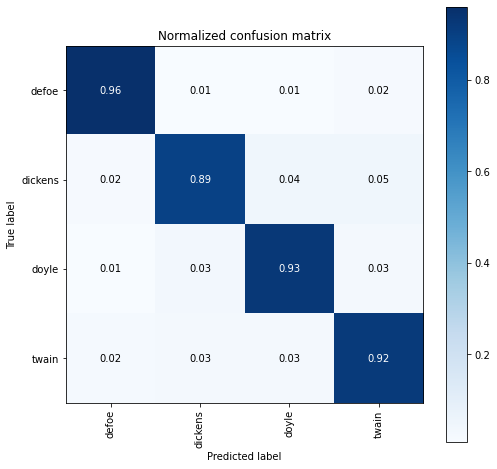

In [29]:
from author_classification.confusion_matrix import plot_cm
plot_cm(df_ev['author'], Y_hat_ev.flatten())

In [ ]:
# Show some examples of bad classifications (eval)

In [30]:
df_ev['author_predicted'] = Y_hat_ev

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [32]:
with pd.option_context('display.max_colwidth', None):
    display(df_ev[df_ev['author'] != df_ev['author_predicted']].groupby('author').sample(2, random_state=288)[['text', 'author', 'author_predicted']])

,text,author,author_predicted
index,,,
9626,"\n\nI immediately cut the twisted flags or rushes which they had bound him\nwith, and would have helped him up; but he could not stand or speak,\nbut groaned most piteously, believing, it seems, still, that he was\nonly unbound in order to be killed",defoe,twain
7562,"A young\nman, anxious for other reasons to marry, is sometimes heard to express\nhis conviction that he might live more cheaply married than single. \nThere could be no assertion more inconsistent with all common\nexperience",defoe,doyle
10538,"Better not to mention the subject,\nanywhere or in any way, and to remove him--for a while at all\nevents--out of France. Even I, safe as an Englishman, and even\nTellson’s, important as they are to French credit, avoid all naming of\nthe matter",dickens,twain
16719,"I had found sublimity and wonder in the dread\nheights and precipices, in the roaring torrents, and the wastes of ice\nand snow; but as yet, they had taught me nothing else. \n\nI came, one evening before sunset, down into a valley, where I was to\nrest",dickens,twain
22094,"\n\n“I had gone up to town about an investment, and I met him in Regent\nStreet with hardly a coat to his back or a boot to his foot. \n\n“‘Here we are, Jack,’ says he, touching me on the arm; ‘we’ll be as\ngood as a family to you",doyle,dickens
24149,"‘I want you, Mr. McFarlane, to cast\n it into proper legal shape. I will sit here while you do so. ’\n\n “I set myself to copy it, and you can imagine my astonishment\n when I found that, with some reservations, he had left all his\n property to me",doyle,dickens
30647,"Such is\nthe legend. Two frame houses were built that year, and several persons\nwere added to the population. A recent number of the leading St. Paul\npaper, the 'Pioneer Press,' gives some statistics which furnish a vivid\ncontrast to that old state of things, to wit: Population, autumn of the\npresent year (1882), 71,000; number of letters handled, first half of\nthe year, 1,209,387; number of houses built during three-quarters of\nthe year, 989; their cost, $3,186,000",twain,defoe
35674,"She became a great favorite with the heads of the\nchurch, and also the people, though she seldom appeared in public. She\nrapidly advanced in esteem, in good report, and in usefulness, and\nAbelard as rapidly lost ground",twain,dickens
